#Clase 7: Aprendizaje no supervisado

El objetivo de este notebook es consolidar el conocimiento sobre los algoritmos de aprendizaje no supervisado revisados en clase. Se realizará experimentación con diversos algoritmos de clusterización y se utilizarán las métricas correspondientes para evaluar su desempeño. 

El alumno deberá completar las preguntas planetadas en el notebook como parte de la evaluación del curso.

## K-means

### Clusterización utilizando k-means

Ejemplo de clusterización en conjunto de datos iris. Se realiza el ajuste del modelo con diferentes valores de k. La gráfica de la inercia muestra cómo esta se reduce a medida que aumenta el valor de k.

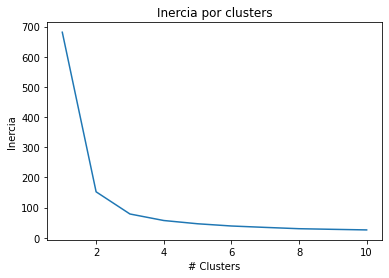

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.cluster import KMeans

iris = datasets.load_iris()
X = iris.data
y = iris.target

inertias = []

#aplicamos metodo elbow clasico
for i in range(1, 11):
    #random state: inicialización de centroides
    kmeans = KMeans(n_clusters = i, max_iter = 300, n_init = 10, random_state = 42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    
plt.plot(range(1, 11), inertias)
plt.title('Inercia por clusters')
plt.xlabel('# Clusters')
plt.ylabel('Inercia') 
plt.show()

A partir de k = 3 no aumenta mucho la inercia por lo que este es un valor adecuado para el número de clusters.

In [ ]:
kmeans = KMeans(n_clusters = 3, max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(X)
print("Inercia: ", kmeans.inertia_)
print("Score: ",kmeans.score(X))

Inercia:  1903.4503741659223
Score:  -1903.4503741659191


In [ ]:
kmeans.score?

In [ ]:
kmeans.inertia_?

**Pregunta 1:** ¿Por qué el valor de score es negativo? ¿Qué representa este valor? 

Rpta. 

Para entender por qué el score es negativo, primero debe comprenderse el concepto de _Inercia_. 'Inercia' es una métrica de la distancia del conjunto de puntos del cluster con respecto de los centroides. En esa medida, 'Inercia' describe qué tan lejos están los puntos de su centroide. El valor de inercia decrece conforme los números de los clusters se incrementan. Esto se debe a que a mayores cluster, menor posibilidad de variabilidad en los puntos con respecto de sus centroides en c/ cluster y, en consecuencia, menor inercia. En esa medida, los valores de inercia irán desde el 0 (inercia nula, cuando todos los puntos tienen la misma distancia con respecto de su centroide) hasta el positivio infinito. 

En esa medida, el Score es el reflejo de esta inercia en rango de valores negativos. Nótese que el score es el valor opuesto (signo opuesto) de la 'Inercia'. Por tanto, el score es el valor opuesto de la reducción de la suma de cuadrados de la distancias de los puntos con respecto de sus centroides. La lectura que se ejecuta sobre el score es equivalente a la de la 'inercia', solo que utilizando valores negativos. Asimismo, no debe confundirse este con una métrica típica de accuracy (que normalmente va de un rango de 0 a 1).



Visualizamos los clusters respecto a las dos primeras características.

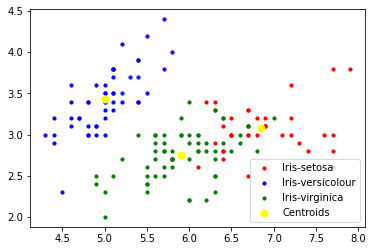

In [ ]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 10, c = 'red', label = 'Iris-setosa')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 10, c = 'blue', label = 'Iris-versicolour')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 10, c = 'green', label = 'Iris-virginica')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s = 50, c = 'yellow', label = 'Centroids')

plt.legend()

Visualizamos los clusters respecto a las otras dos características.

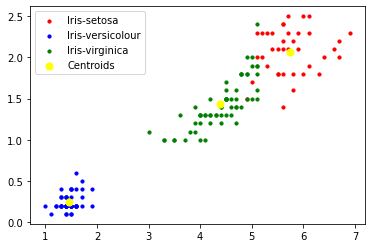

In [ ]:
plt.scatter(X[y_kmeans == 0, 2], X[y_kmeans == 0, 3], s = 10, c = 'red', label = 'Iris-setosa')
plt.scatter(X[y_kmeans == 1, 2], X[y_kmeans == 1, 3], s = 10, c = 'blue', label = 'Iris-versicolour')
plt.scatter(X[y_kmeans == 2, 2], X[y_kmeans == 2, 3], s = 10, c = 'green', label = 'Iris-virginica')

plt.scatter(kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:,3], s = 50, c = 'yellow', label = 'Centroids')

plt.legend()

Comparemos la ejecución de Acelerated KMeans (algoritmo por defecto) con Kmeans full.

In [ ]:
%timeit -n 50 KMeans(algorithm="elkan").fit(X)
%timeit -n 50 KMeans(algorithm="full").fit(X)

50 loops, best of 3: 40.3 ms per loop
50 loops, best of 3: 53.7 ms per loop


El método elbow no es el mejor para tomar los K ideales

In [ ]:
#vemos las inercias como metrica del elbow: no son la mejor para tomar el mejor K!!!!!!
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]
#observar la variación de las inercias conforme aumenta K
#sin la gráfica intuitiva, ¿cuál sería el valor correcto?
inertias

[681.3706,
 152.34795176035792,
 78.85144142614601,
 57.228473214285714,
 46.44618205128205,
 39.03998724608725,
 34.40900974025974,
 30.063110617452725,
 27.98222120518688]

La métrica **Silhouette Score** permite realizar una mejor evaluación del modelo. 

In [ ]:
from sklearn.metrics import silhouette_score
#'kmeans_per_k' son los diferentes modelos kmeans x K

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

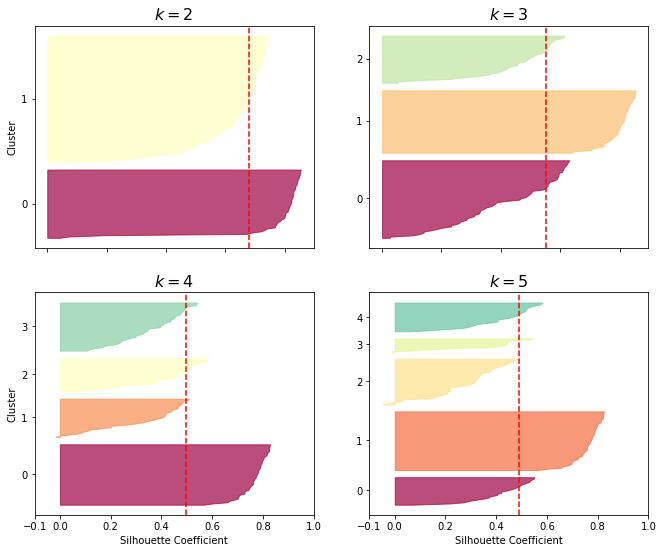

In [ ]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (2, 4):
        plt.ylabel("Cluster")
    
    if k in (4, 5):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

Referencia:
_Como muestran los gráficos anteriores, n_clusters = 2 tiene la mejor puntuación de silueta promedio de alrededor de 0,75 y todos los cluster están por encima del promedio, lo que indica de que es una buena opción. Además, el grosor del gráfico de silueta da una indicación del tamaño de cada grupo. El gráfico muestra que el grupo 1 tiene casi el doble de muestras que el grupo 2. Sin embargo, a medida que aumentamos n_clusters a 3 y 4, la puntuación de silueta promedio disminuyó drásticamente. Entonces, los buenos n_clusters tendrán una puntuación media de silueta muy superior a 0,5 y todos los grupos tendrán una puntuación superior a la media._

En el caso de Iris podemos observar que hay un cluster bien definido y los otros dos clusters no tienen mucha separación. El cluster Versicolor destaca como un buen cluster para los 4 valores de k. Los otros dos clusters apenas pasan la linea roja para k=3 y tienen un peor desempeño para el resto de valores de k.

***

En conclusión, _**la idea central es poder discenir el valor de K que logre sobrepasar todos los cluster del lado derecho de la línea roja (valor medio de los coeficientes de silueta)**_.

***

Revisemos el score de siluetas para otra distribución de datos:

Adaptado del ejemplo de score de siluetas de sklearn.

Para n_clusters = 2 El score de silueta promedio es : 0.7049787496083262
Para n_clusters = 3 El score de silueta promedio es : 0.5882004012129721
Para n_clusters = 4 El score de silueta promedio es : 0.6505186632729437
Para n_clusters = 5 El score de silueta promedio es : 0.5745566973301872
Para n_clusters = 6 El score de silueta promedio es : 0.43902711183132426


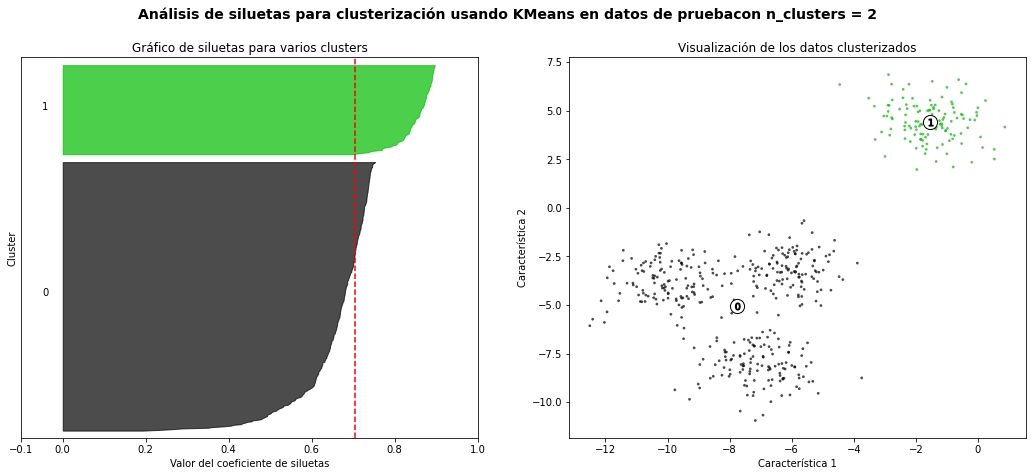

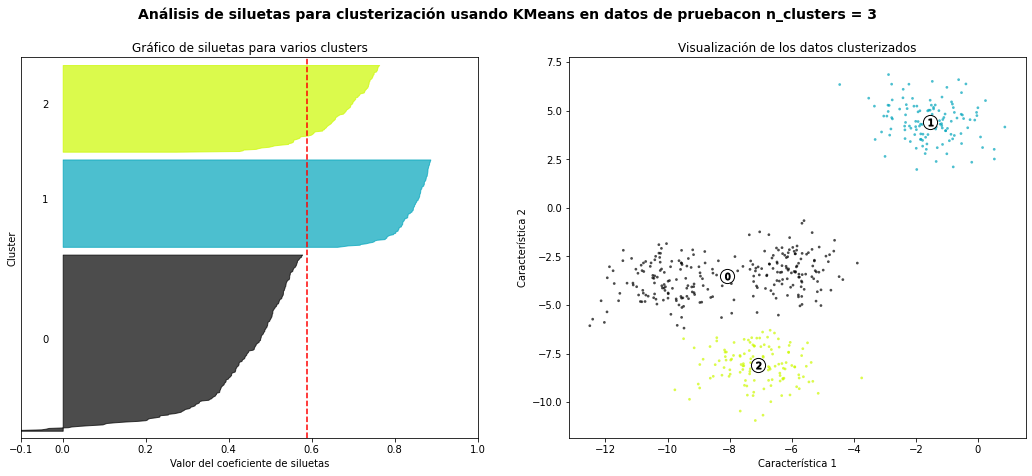

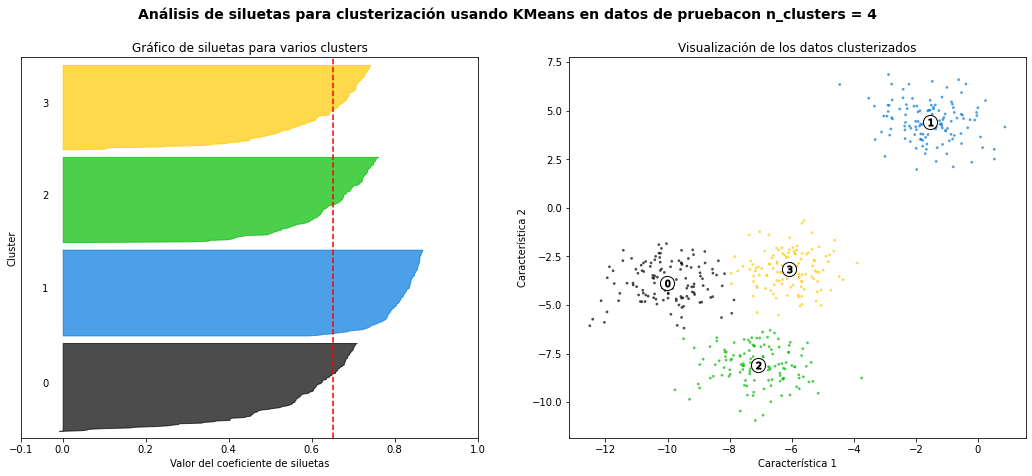

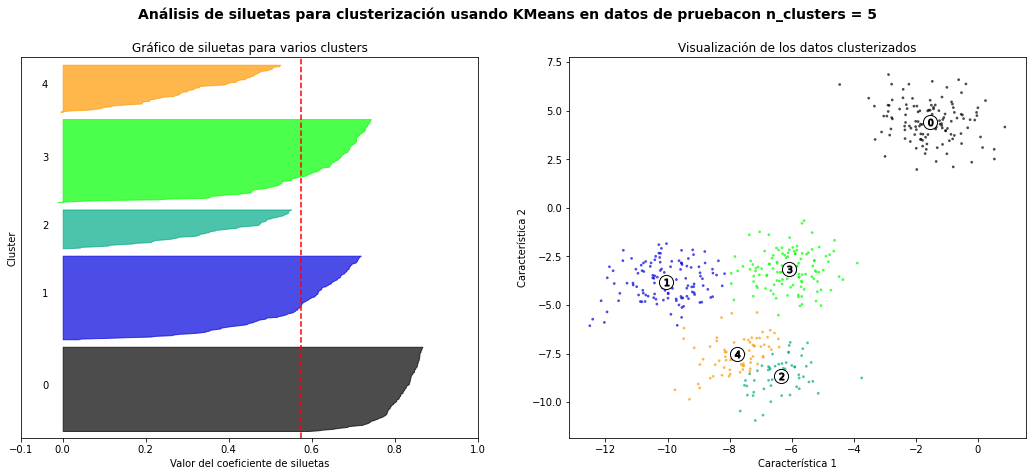

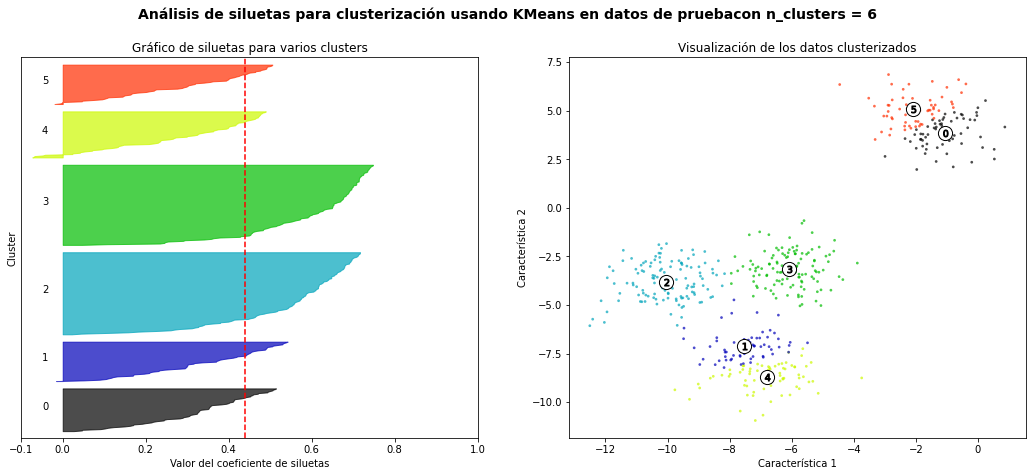

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generando data de ejemplo usando blobs
# El conjunto de datos tiene 3 clusters juntos y uno alejado
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  

# Se explorará las soluciones para 2 a 6 clusters
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])

    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Se ejecuta el algoritmo KMeans para cada cluster y se genera las etiquetas
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # Se utiliza la función silhouette_score para obtener el score de silueta promedio
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "El score de silueta promedio es :", silhouette_avg)

    # Se utiliza la función silhouette_samples para obtener el score de cada instancia
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    # Se genera el gráfico de comparación.
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10 

    ax1.set_title("Gráfico de siluetas para varios clusters")
    ax1.set_xlabel("Valor del coeficiente de siluetas")
    ax1.set_ylabel("Cluster")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([]) 
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_

    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Visualización de los datos clusterizados")
    ax2.set_xlabel("Característica 1")
    ax2.set_ylabel("Característica 2")

    plt.suptitle(("Análisis de siluetas para clusterización usando KMeans en datos de prueba"
                  "con n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

**Pregunta 2:** Según los gráficos, ¿Cuál es el mejor valor de n_clusters? Justifique su respuesta.

Rpta. El mejor valor de n_clusters es **4**.

Esta elección se debe a que ocurren tres condiciones:

1. Todos los clusters superan holgadamente el valor medio del coeficiente de siluetas para el valor K seleccionado.

2. La dimensión/proporción de los cluster construidos para el valor de K seleccionado son equivalentes.

3. El score de silueta promedio para el K seleccionado es significativamente mayor a 0.5.

Nótese que los puntos 1 y 3 también se cumplen para K = 2. Sin embargo, la proporción de estos clusters es extremadamente desigual. Por ende, se optó por K = 4 como la alternativa más adecuada.

### Minibatch KMeans

Se puede utilizar un objeto memmap para alimentar un dataset muy grande a la clase MiniBacthKMeans. Esta utiliza un archivo (my_mnist.data en este caso) para almeacenar la data en el disco.

In [ ]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    mnist["data"], mnist["target"], random_state=42)

filename = "my_mnist.data"

# 'np.memmap' mapea los datos en un archivo temporal
# de ese modo, cargamos los datos pero sin tener que usar execso de memoria
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:] = X_train

Podemos comparar el tiempo de ejecución de MiniBatchKMeans contra KMeans.

In [ ]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
%timeit minibatch_kmeans.fit(X_mm)

1 loop, best of 3: 6.08 s per loop


In [ ]:
minibatch_kmeans.score(X_mm)

-135436650000.0

**Advertencia:** las siguientes instrucciones pueden demorar unos minutos en ejecutar.

In [ ]:
kmeans = KMeans(n_clusters = 10, random_state=42)
kmeans.fit(X_train)
#%timeit kmeans.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [ ]:
kmeans.score(X_train)

-133838725467.40955

### Compresión de imágenes usando KMeans

Se utilizará las imágenes de ejemplo de sklearn.datasets. Se normaliza los datos y se utiliza el algoritmo kmeans para agrupar cada pixel en 16 grupos.

In [ ]:
from sklearn.datasets import load_sample_images

# Cargando la imagen de prueba
dataset = load_sample_images() 
A = dataset.images[0] 
A = np.asarray(A, dtype=float)

# Dividir entre 255 para que los valores estén en el rango 0 - 1
A = A / 255

# Tamaño de la imagen
img_size = A.shape

# Convertir la imagen en una matrix N x 3, donde N = número de pixels.
# Cada fila contiene los valores de Rojo, Verde y Azul
# Esto nos da la matriz del conjunto de datos X que usaremos con k-means
X = A.reshape((img_size[0] * img_size[1], 3))

# Parámetros para el algoritmo KMeans
K = 2
max_iter = 10
kmeans = KMeans(n_clusters = K, random_state=42, max_iter = max_iter)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

Se utiliza los centroides para reconstruir la imagen en base al color de los centroides de cada cluster.

Text(0.5, 1.0, 'Comprimida, con 2 colores')

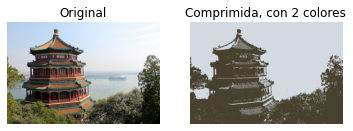

In [ ]:
X_recovered =  kmeans.cluster_centers_[kmeans.labels_]

# Transformar la imagen recuperada en sus dimensiones originales
X_recovered = X_recovered.reshape((img_size[0], img_size[1], 3))

# Mostrar la imagen original y la recuperada
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.axis('off')
ax1.imshow(A)
ax1.set_title('Original')
ax2.axis('off')
ax2.imshow(X_recovered)
ax2.set_title('Comprimida, con %d colores' % K)


**Pregunta 3:** Comprima la imágen de su preferencia. Elija un número de colores que permita preservar razonablemente los detalles. Puede usar la librería PIL para importar una imagen y np.asarray para transformarla en un arreglo de numpy.

In [ ]:
from PIL import Image 
# Completar...
myImg = Image.open('gaseosas-3(3).jpg') 
myImg = np.asarray(myImg, dtype=float)

In [ ]:
myImg = myImg / 255

pic_size = myImg.shape

X_input_picture = myImg.reshape((pic_size[0] * pic_size[1], 3))

In [ ]:
K = 3
max_iter = 15
kmeans = KMeans(n_clusters = K, random_state=42, max_iter = max_iter)
kmeans.fit(X_input_picture)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=15,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

Text(0.5, 1.0, 'Comprimida, con 3 colores')

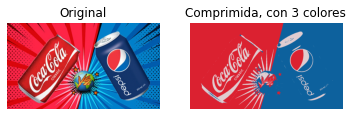

In [ ]:
X_recovered =  kmeans.cluster_centers_[kmeans.labels_]

X_recovered = X_recovered.reshape((pic_size[0], pic_size[1], 3))

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.axis('off')
ax1.imshow(myImg)
ax1.set_title('Original')
ax2.axis('off')
ax2.imshow(X_recovered)
ax2.set_title('Comprimida, con %d colores' % K)

Rpta. El valor mínimo para preservar razonablemente los detalles (diferencia de segmentación de color rojo/azul para CocaCola y Pepsi con sus repectivos logos) corresponde a K = 3.

Imagen seleccionada: https://i.ytimg.com/vi/I0ZY2D9ijdI/maxresdefault.jpg 

### Segmentacion de imagenes usando KMeans

Adaptado del ejemplo de KMeans para segmentación de imagenes del libro Hands on Machine Learning with Sckit-Learn, Teras & Tensorflow - Aurélien Géron (O’Really) 
https://github.com/ageron/handson-ml2

Se clusteriza la imagen para diferentes valores de K. En este caso, K es el número de segmentos deseado. Para separar la imagen de la flor del fondo basta con K = 2.

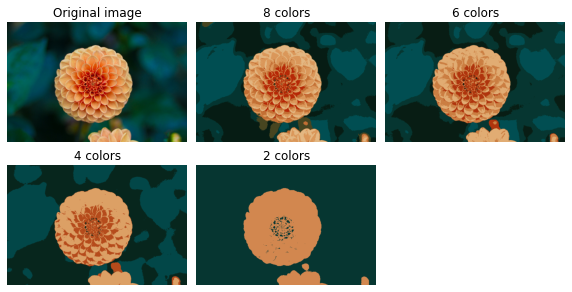

In [ ]:
A = dataset.images[1] 

# Normalizar imágen
A = A / 255

X = A.reshape(-1, 3)

segmented_imgs = []

#utilizamos estos n_colors como K 
#preprocesamiento de imágenes
n_colors = (8, 6, 4, 2)

for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(A.shape))

plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(A)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

plt.show()

## DBSCAN

Adaptado del ejemplo de DBSCAN del libro Hands on Machine Learning with Sckit-Learn, Teras & Tensorflow - Aurélien Géron (O’Really) 
https://github.com/ageron/handson-ml2


Utilizaremos el dataset moons de sklearn. Este contiene dos clases distribuidas en forma de lunas. Visualizamos el conjunto de datos.

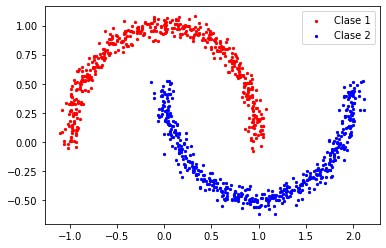

In [ ]:
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

plt.scatter(X[y == 0, 0], X[y == 0, 1], s = 5, c = 'red', label = 'Clase 1')
plt.scatter(X[y == 1, 0], X[y == 1, 1], s = 5, c = 'blue', label = 'Clase 2')
plt.legend()
plt.show()

Entrenamos dos modelos DBSCAN en los datos.

In [ ]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6])

In [ ]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)
np.unique(dbscan2.labels_)

array([0, 1])

Graficamos el resultado de cada ejecución de DBSCAN:

In [ ]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

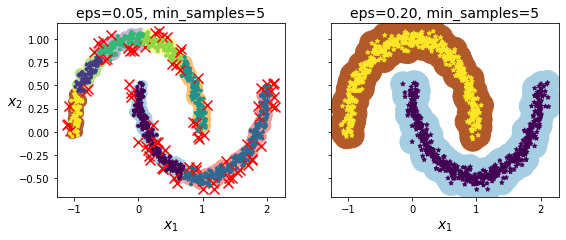

In [ ]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()

**Pregunta 4:** ¿Qué diferencia hay entre los gráficos de las dos ejecuciones? Explique a que se deben estas diferencias.

Rpta. Existen dos diferencias. 

- La primera diferencia es gráfica. Puede notarse que el primer agrupamiento no logra diferenciar correctamente los dos grupos 'media luna' de forma independiente. Todo lo contrario, crea pequeños agrupamientos de densidad al interior de cada uno de estas dos unidades. Esto da la impresión de que el valor de densidad varía significativamente entre los grupos (lo cual no es así).

- El fenómeno anterior se debe al valor de 'epsilon' asignado. En el caso del agrupamiento correcto de las dos unidades 'media luna', el epsilon tiene un valor de 0.20. En contraste, en el escenario del primer agrupamiento no-ideal, el valor del epsilon es de apenas 0.05.

Nótese que el _epsilon_ es la máxima distancia entre dos muestras para que puedan ser consideradas como vecinos. En esa medida, a mayor valor de _eps_, mayor será la distancia máxima permitida para que dos puntos puedan considerarse vecinos (tomando en cuenta el valor límite de 'm' o 'min_samples').  


## Gaussian Mixture Models

Adaptado del ejemplo de GMM del libro Hands on Machine Learning with Sckit-Learn, Teras & Tensorflow - Aurélien Géron (O’Really) 
https://github.com/ageron/handson-ml2

Exploraremos diferentes datasets con distribuciones de origen gaussiano para experimentar con el algoritmo GMM.

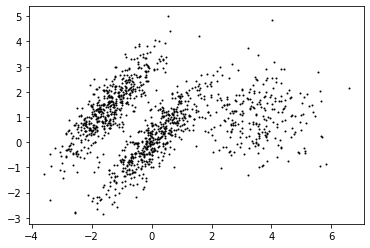

In [ ]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
plt.show()

Entrenamos un GMM en el dataset generado por las distribuciones gaussianas.

In [ ]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

Se puede utilizar el modelo para generar muestras nuevas de la distribución original.

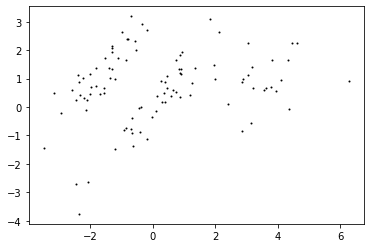

In [ ]:
X_new, y_new = gm.sample(100)
plt.plot(X_new[:, 0], X_new[:, 1], 'k.', markersize=2)
plt.show()

**Pregunta 5:** ¿Qué particularidad se puede observar en el gráfico de las muestras generadas? Pruebe generar y graficar un mayor número de muestras.

Rpta. La particularidad más resaltante en el gráfico de las muestras generadas es la preservación de los clusters inherentes al conjunto de datos (ligados, por supuesto, a su distribución). 

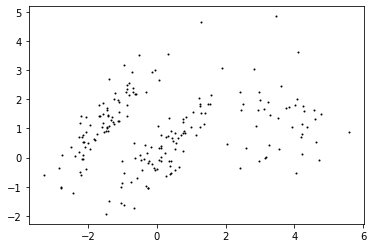

Puede notarse como, a mayor número de muestras, los clusters inherentes al conjunto de datos original se hace mucho más visible


In [ ]:
#generando gráfica con un número mayor de muestras
X_new, y_new = gm.sample(200)
plt.plot(X_new[:, 0], X_new[:, 1], 'k.', markersize=2)
plt.show()
print("Puede notarse como, a mayor número de muestras, los clusters inherentes al conjunto de datos original se hace mucho más visible")

Grafiquemos las fronteras de decisión y los contornos de densidad obtenidos por el modelo.

In [ ]:
from matplotlib.colors import LogNorm

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)
    
def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='w', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
        
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)

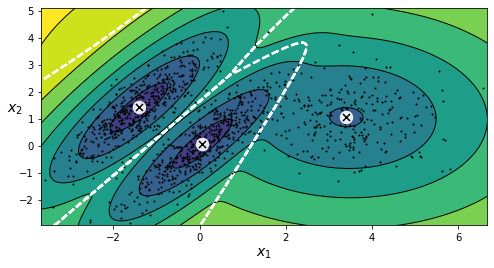

In [ ]:
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X)
plt.show()

Como se vió en clase, es posible restringir las matrices de covarianza usando el parámetro covariance_type:

* "full" (por defecto): sin restricción, los clusters pueden tomar cualquier forma elipsoidal.
* "tied": los clusters deben tener la misma forma que puede ser cualquier elipsoide.
* "spherical": los clusters deben ser esféricos, solo varía el diámetro.
* "diag": los clusters pueden tener cualquier forma elipsoidal pero los ejes de la elipse deben ser paralelos a los ejes.

In [ ]:
#distintos tipos de matriz de covarianza
#esto determinara el tipo de figura de cada agrupamiento
#diagonal
#sferica
#'tied'
#o 'full', que es todas

gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)

gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)

gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)

gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)

gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

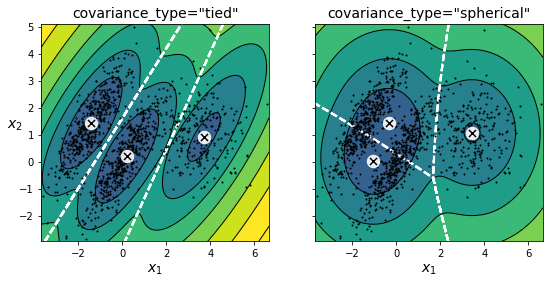

In [ ]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)
plt.show()

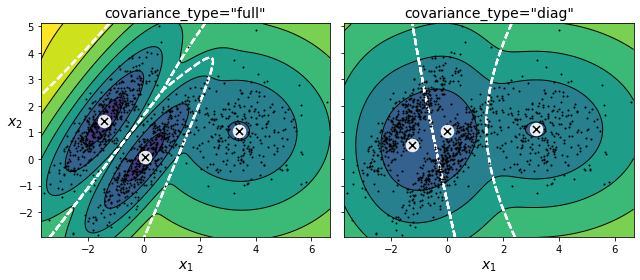

In [ ]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

### Detección de anomalías usando GMM


GMM puede usarse para detectar anomalías, basta explorar las instancias ubicadas en zonas de baja densidad. Se debe definir un límite de densidad para diferenciar una anomalía. Por ejemplo, si se conoce que 4% es la tasa de productos defectuosos en una fábrica, se puede usar como límite el valor de densidad que mantenga el 4% de instancias fuera.

In [ ]:
# Cálculo del límite de densidad que permite descartar el 4% de las instancias.
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

Podemos imprimir las anomalías respecto a las fronteras de decisión y los contornos de densidad obtenidos por el modelo.

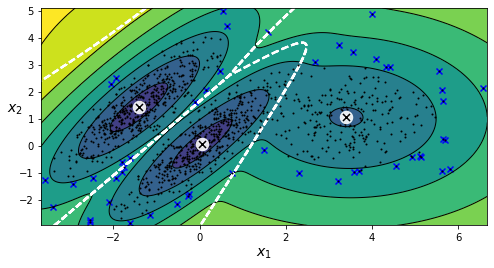

In [ ]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='b', marker='x')
plt.ylim(top=5.1)

plt.show()

**Pregunta 6:** ¿Cuántas instancias se tienen en total? ¿Cuántas fueron detectadas como anomalías?

Rpta. Para un valor límite de densidad de 4%, se posee 3 instancias en total. Al rededor de estas, se encontraron 45 anomalías aproximadamente. 

Nótese que estas anomalías se encuentran dentro del valor máximo del conjunto:

$samples * densitiy limit$

Donde

$1250 * 4%$ $= 50$


### GMM: Métricas de evaluación

Las métricas de evaluación revisadas para el algoritmo GMM son Bayesian information criterion (BIC) y Akaike information criterion (AIC). Se utilizarán estas métricas para detectar gráficamente el mejor valor de k para el conjunto de datos trabajado previamente. También se utilizará gridsearch para encontrar el mejor valor de k y covariance_type en base a la métrica BIC.

Entrenamiento de modelos GMM para k ∈ {1,2,3, ... ,11}

In [ ]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

Calculo de métricas BIC y AIC para cada modelo.

In [ ]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

Gráfica de los indicadores BIC y AIC para cada valor de k.

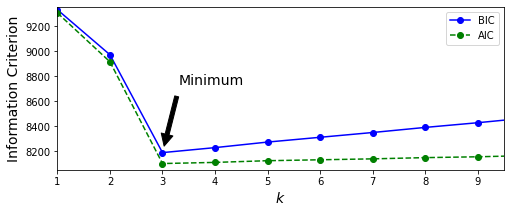

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
plt.show()

Se utiliza gridsearch para determinar el mejor valor de k y covariance_type.

In [ ]:
min_bic = np.infty

#gridsearch para encontrar el mejor K y la mejor matriz de cov. para el Gaussiano 
for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).bic(X)
        if bic < min_bic:
            print(bic)
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

9330.418496222055
8971.197133122107
8189.733705221635


In [ ]:
best_k,best_covariance_type

(3, 'full')

**Pregunta 7:** Replique el cálculo de mejores parámetros utilizando la métrica AIC. ¿Qué información nos da este indicador?

In [ ]:
## Completar
min_aic = np.infty

#gridsearch para encontrar el mejor K y la mejor matriz de cov. para el Gaussiano 
for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        aic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).aic(X)
        if aic < min_aic:
            print(aic)
            min_aic = aic
            best_k = k
            best_covariance_type = covariance_type

9304.764002070573
8914.757245988847
8102.508425106597


In [ ]:
#best parameters using AIC
best_k,best_covariance_type

(3, 'full')

Rpta. El _Akike Information Criterion_ nos brinda una métrica de ponderación para los modelos que más se ajusten al conjunto de datos. En este caso, ha elegido un K = 3 y un tipo 'full' para la matriz de covarianza.

### Bayesian Gaussian Mixture Model

En vez de realizar una búsqueda manual del número de clusters, se puede utilizar la clase BayesianGaussianMixture. Este modelo parte de un número inicial de componentes (que debe ser mayor al número de clusters) y asigna un peso de 0 a los componentes innecesarios. Podemos volver a experimentar con el conjunto de datos asumiendo que el número de componentes es menor a 10.

In [ ]:
from sklearn.mixture import BayesianGaussianMixture

#'n_components' no es exacto: es MAXIMO
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)

/usr/local/lib/python3.6/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=100, mean_precision_prior=None,
                        mean_prior=None, n_components=10, n_init=10,
                        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=None,
                        weight_concentration_prior_type='dirichlet_process')

Si revisamos los pesos del modelo, vemos que ha descartado 7 clusters, manteniendo solo 3.

In [ ]:
np.round(bgm.weights_, 2)

array([0.4 , 0.  , 0.  , 0.  , 0.39, 0.2 , 0.  , 0.  , 0.  , 0.  ])

Podemos graficar nuevamente las fronteras de decisión y los contornos de densidad obtenidos por el modelo.

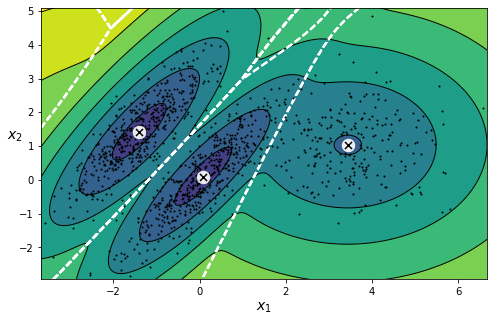

In [ ]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

## Comparación de modelos

Adaptado de los ejemplos de clusterización de Sklearn.

El ejemplo muestra las características de diferentes algoritmos de clusterización en conjuntos de datos 2D de diferentes formas. A excepción del último conjunto de datos, los parámetos de los conjuntos han sido configurados para producir clusters diferenciables. Algunos modelos son más sensibles a ciertas configuraciones que otros.

El último conjunto de datos es un ejemplo de datos homogeneos, no tiene solución como problema de clusterizacion. A pesar de que este experimento puede dar luces sobre el comportamiento de cada algoritmo, es posible que este no aplique para conjuntos de datos de dimensionalidad alta.

Automatically created module for IPython interactive environment


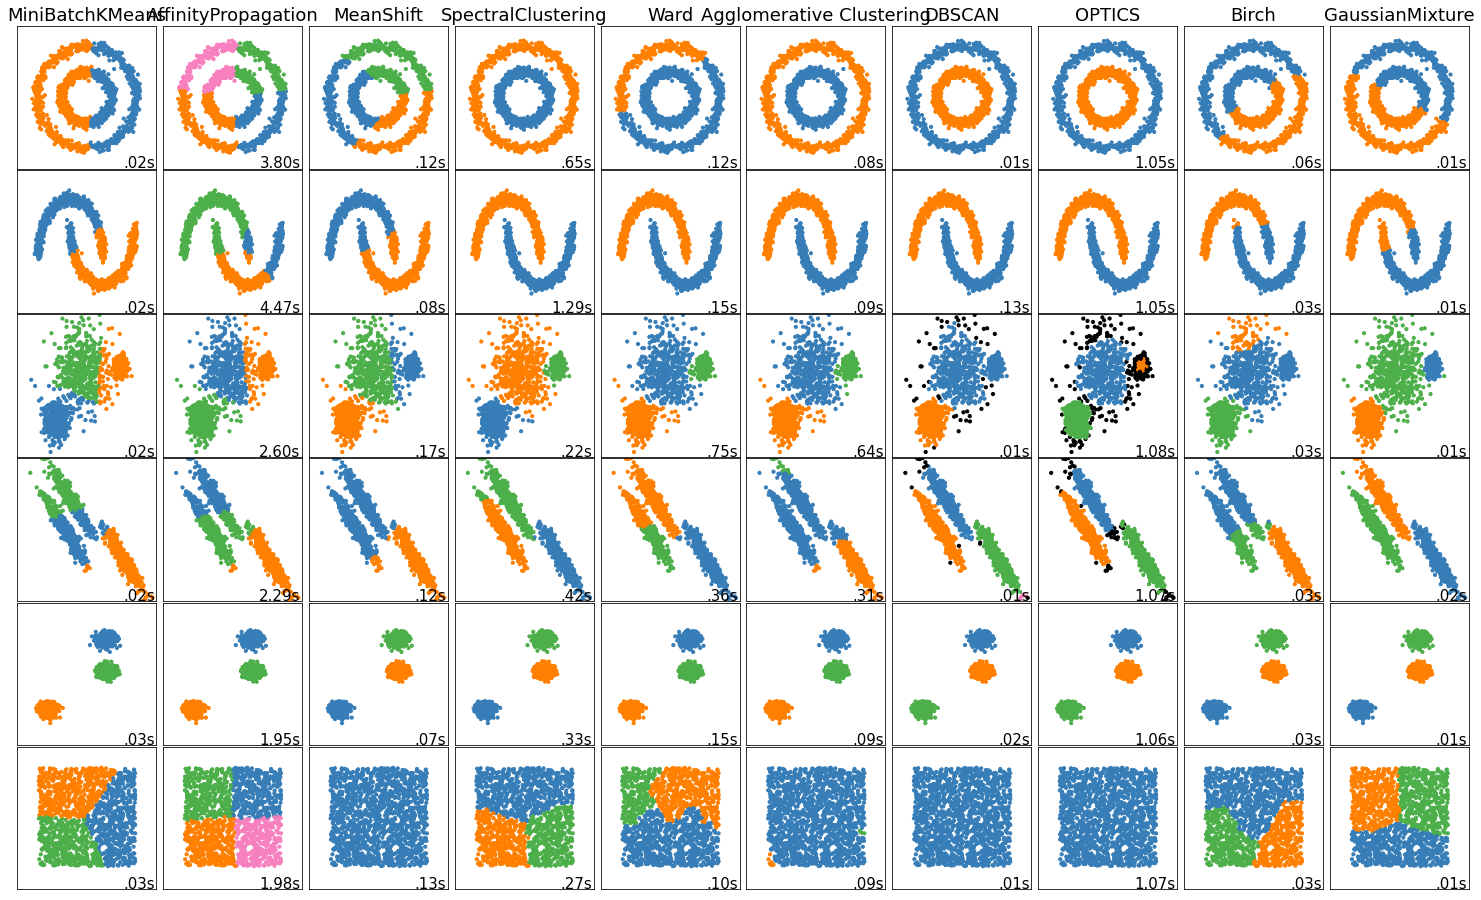

In [ ]:
%matplotlib inline

print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Creación de datasets. Se crean conjuntos de datos de tamaño moderado, que permitan evaluar la 
# escalabilidad de los algoritmos sin elevar demasiado el tiempo de ejecución.
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Datos con distribución anisotropica 
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# Datos con varianzas variadas
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Parámetros de agrupamiento
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

#parametros generales
default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

#parametros especificos 
datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

#iteramos sobre combinatoria de parametros para generar los modelos
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # Actualización de parámetros para cada dataset
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # Normalización de datos
    X = StandardScaler().fit_transform(X)

    # Estimacion del ancho de banda requerido por el algoritmo Meanshift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # Matriz de conectividad requerida por el algoritmo Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # la matriz de conectividad debe ser simétrica
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Creación de modelos de clusterización
    # ============
    
    # Meanshift
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    
    # Mini Batch KMeans
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    
    # Ward
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    
    # Spectral Clustering
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    
    # DBSCAN
    dbscan = cluster.DBSCAN(eps=params['eps'])
    
    # OPTICS
    # NO hemos definido aqui el epsilon maximo (eps) por lo que está trabajando con el max epsilon
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    
    # Affinity Propagation
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    
    # Agglomerative Clustering
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    
    # Birch
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    
    # Gaussian Mixture Model
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('Agglomerative Clustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # Filtro de warnings
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # Color negro para outliers, en caso existan
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

**Pregunta 8:** Elija uno de los conjuntos de datos de la carpeta código/data de la sección correspondiente a la clase 7 (Aprendizaje no supervisado) de PAIDEIA. Sigua los pasos para realizar el agrupamiento de un conjunto de datos desconocido.

1) Cargar el dataset seleccionado y explorar los datos.

In [ ]:
# Parte 1
df=pd.read_csv(
    "easy.txt", delimiter="\t", 
    header=None, names=["a", "b", "c"]
    )

dataset.head()

,a,b,c
0,9.802,10.132,1
1,10.350,9.768,1
2,10.098,9.988,1
3,9.730,9.910,1
4,9.754,10.430,1


In [ ]:
dataset.describe()

,a,b,c
count,600.000000,600.000000,600.000000
mean,9.997540,9.979520,8.000000
std,3.266002,3.264521,4.324099
min,3.402000,3.178000,1.000000
25%,8.287500,8.057000,4.000000
50%,9.664000,9.979000,8.000000
75%,11.883500,11.851500,12.000000
max,17.124000,17.012000,15.000000


2) Exploración gráfica de los puntos para determinar visualmente los posibles clusters.

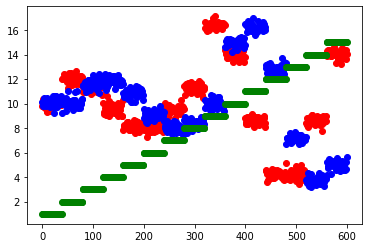

In [ ]:
# Parte 2
plt.plot(df.a,'o',color='red')
plt.plot(df.b,'o',color='blue')
plt.plot(df.c,'o',color='green')
plt.show()

3) Realizar cáculos o transformaciones adicionales si el algoritmo lo requiere (Ej. normalización).

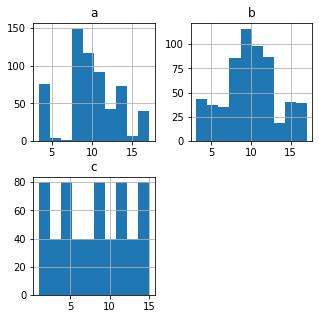

In [ ]:
# Parte 3
df.hist(figsize = (5, 5), bins=10)
plt.show()

In [ ]:
#debido a la distribución de los datos, no es necesaria la normalización
#X = StandardScaler().fit_transform(df)

In [ ]:
X = df[['a','b']].values
Y = df['c'].values

4) Ejecutar alguno de los algoritmos de clusterización y estratégias estudiadas para encontrar el mejor número de clusters.



In [ ]:
# Parte 4


#aplicamos gridsearch para encontrar el mejor K y la mejor cov_matrix
#utilizaremos al Akike Information Criterion como métrica de elección

min_aic = np.infty

for k in range(1, 20):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        aic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).aic(X)
        if aic < min_aic:
            min_aic = aic
            best_k = k
            best_covariance_type = covariance_type

#obtenemos el valor de K y la mejor cov_matrix elegida:
print(f"The best k-val for the GMM is: {best_k}")
print(f"The best covMatrix for the GMM is: {best_covariance_type}")

The best k-val for the GMM is: 16
The best covMatrix for the GMM is: tied


5) Graficar el resultado de la cluterización.

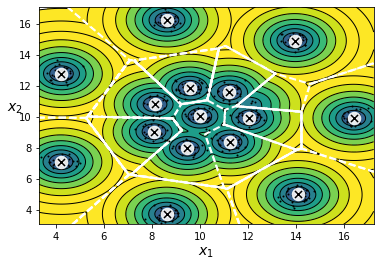

In [ ]:
# Parte 5
clf = GaussianMixture(
    n_components=best_k, 
    n_init=10,
    covariance_type=best_covariance_type,
    random_state=42)

clf.fit(X)

plot_gaussian_mixture(clf, X)